In [2]:
import os
import uuid
import json
import warnings
import random
import copy
import pickle
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchmetrics as tm

from graphlime import GraphLIME
from tqdm.notebook import tqdm
from torch_geometric.data import Data as tgData
from mumin_explainable.architectures.graphs import GAT

%matplotlib inline

warnings.filterwarnings('ignore')

In [3]:
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

# Load data

In [12]:
LANGUAGE = 'multilingual'
MODALITY = 'graph'
TEXT_DIM = 100


data = pickle.load(open(f'./data/preload/data-jupyter_{MODALITY}_{LANGUAGE}.pickle', 'rb'))
data.x.shape

torch.Size([4061, 812])

# Robustness batch experiment

In [13]:
for PER_NOISE in tqdm([0.0, 0.01, 0.1, 0.25, 0.5, 0.75, 1]):

    EXP_ID = uuid.uuid4().hex

    # Setup noiseness
    NUM_NOISY_FEATURES = int(data.x.shape[1] * PER_NOISE)

    noisy_features = torch.randn((data.x.shape[0], NUM_NOISY_FEATURES))
    noisy_features = noisy_features - noisy_features.mean(1, keepdim=True)

    noisy_features_data = tgData(
        x=torch.cat([data.x, noisy_features], dim=-1),
        y=data.y,
        train_mask=data.train_mask,
        val_mask=data.val_mask,
        test_mask=data.test_mask,
        edge_index=data.edge_index)

    # Train model
    hparams = {
        'input_dim': noisy_features_data.num_node_features,
        'hidden_dim': 16,
        'output_dim': max(noisy_features_data.y).item() + 1
    }
    
    MODEL_NAME = f'{LANGUAGE}_{MODALITY}_noise_batch'


    model = GAT(**hparams).double()

    lr = 0.005
    epochs = 400

    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    f1_score = tm.classification.f_beta.F1Score(task='multiclass', num_classes=2, average='none')
    best_f1macro = -1

    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        
        output = model(noisy_features_data.x, noisy_features_data.edge_index)
        loss = F.nll_loss(output[noisy_features_data.train_mask], noisy_features_data.y[noisy_features_data.train_mask])
        
        loss.backward()
        optimizer.step()
        
        f1 = f1_score(output[noisy_features_data.train_mask], noisy_features_data.y[noisy_features_data.train_mask])
        f1macro = torch.mean(f1)

        if f1macro > best_f1macro:
            best_f1macro = f1macro
            torch.save(model.state_dict(), f'./data/models/{MODEL_NAME}.pth')

    # Load best model
    model = GAT(**hparams).double()
    model.load_state_dict(torch.load(f'./data/models/{MODEL_NAME}.pth'))
    model.eval()

    # Eval explainability
    graphlime = GraphLIME(model, hop=2, rho=0.1, cached=True)
    test_nodes = np.where(noisy_features_data.test_mask == True)[0]
    TOP_K = 10

    num_noise_feats = []
    per_noise_feats = []

    for node_idx in tqdm(test_nodes):

        coefs = graphlime.explain_node(int(node_idx), noisy_features_data.x, noisy_features_data.edge_index)

        feat_indices = coefs.argsort()[-TOP_K:]
        feat_indices = [idx for idx in feat_indices if coefs[idx] > 0.0]
        num_noise_feat = sum(idx >= data.x.shape[1] for idx in feat_indices)
        num_noise_feats.append(num_noise_feat)
        per_noise_feats.append(num_noise_feat / len(feat_indices) if len(feat_indices) > 0 else 0)

    try:
        with open('./data/results/robustness-v2-batch-jupyter.json', 'r') as f:
            robustness_dict = json.load(f)
    except:
        robustness_dict = {}
    finally:
        with open('./data/results/robustness-v2-batch-jupyter.json', 'w') as f:
            robustness_dict[EXP_ID] = {
                'PER_NOISE': PER_NOISE,
                'NUM_NOISE_FEATURES': NUM_NOISY_FEATURES,
                'num_noise_feats': [int(x) for x in num_noise_feats],
                'avg_num_noise_feats': sum(num_noise_feats)/len(num_noise_feats),
                'per_noise_feats': [float(x) for x in per_noise_feats],
                'avg_per_noise_feats': sum(per_noise_feats)/len(per_noise_feats),
                'modality': MODALITY,
                'language': LANGUAGE
            }
            json.dump(robustness_dict, f)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

## Joint analysis

In [21]:
with open('./data/results/robustness-v2-batch-jupyter.json', 'r') as f:
    robustness_dict = json.load(f)

robustness_df = pd.DataFrame(robustness_dict).T
robustness_df.columns = map(str.upper, robustness_df.columns)
robustness_df['MODALITY'][robustness_df['MODALITY'] == 'graph'] = 'Graph-based'
robustness_df['MODALITY'][robustness_df['MODALITY'] == 'text'] = 'Text-based'
robustness_df['MODALITY'][robustness_df['MODALITY'] == 'multimodal'] = 'Multimodal'
robustness_df

,PER_NOISE,NUM_NOISE_FEATURES,NUM_NOISE_FEATS,AVG_NUM_NOISE_FEATS,PER_NOISE_FEATS,AVG_PER_NOISE_FEATS,MODALITY,LANGUAGE
c40e2c774c6c4896bd3c4175e5749e44,0.0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,Multimodal,multilingual
096cee2a3467424bbcb179fe48c04bb9,0.01,9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.050114,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.026196,Multimodal,multilingual
fd5de0acbefb42b881c218ffca4bbcff,0.1,91,"[0, 1, 0, 0, 2, 2, 1, 1, 0, 0, 0, 1, 0, 0, 1, ...",0.492027,"[0.0, 1.0, 0.0, 0.0, 0.6666666666666666, 1.0, ...",0.245634,Multimodal,multilingual
92dc8916b6024b328450032e7861b250,0.25,228,"[1, 1, 1, 0, 1, 1, 2, 1, 2, 1, 1, 1, 0, 2, 0, ...",0.883827,"[0.5, 0.5, 1.0, 0.0, 0.5, 0.5, 1.0, 0.5, 1.0, ...",0.441534,Multimodal,multilingual
9bed807e3041416784848af593f569da,0.5,456,"[1, 2, 1, 3, 1, 2, 1, 3, 1, 0, 2, 1, 1, 0, 2, ...",1.430524,"[1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.5, 1.0, 0.5, ...",0.713743,Multimodal,multilingual
68d64318bbb1495d95653eb4dc019cbe,0.75,684,"[2, 2, 2, 1, 0, 1, 0, 2, 1, 2, 2, 2, 3, 2, 2, ...",1.77221,"[1.0, 1.0, 1.0, 0.5, 0.0, 0.5, 0.0, 1.0, 0.5, ...",0.863326,Multimodal,multilingual
ce49d68ee71341da83cc0fda068ddc51,1,912,"[2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, ...",1.790433,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.666...",0.889901,Multimodal,multilingual
280ae00098844ad186f94bbb79f6a562,0.0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,Text-based,multilingual
239bf7b0c8da442cb7e7f56173125779,0.01,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,Text-based,multilingual
bc2497a37a264bb4b98cd947f3c38422,0.1,10,"[0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0.148064,"[0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.33333333...",0.073652,Text-based,multilingual


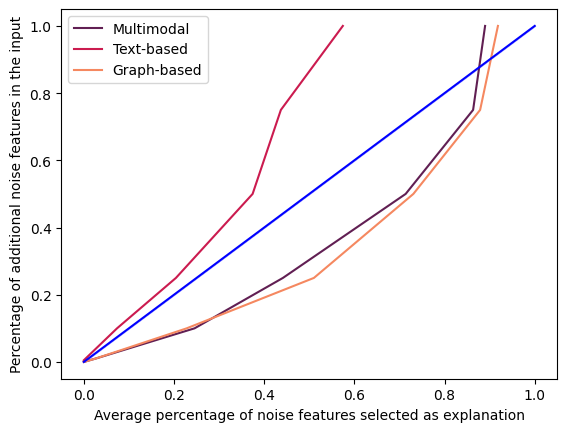

In [24]:
# repensar essa visualização em termos de TPR e FPR (ROC) ou Precision e Recall (PR) ou AUC
sns.lineplot(data=robustness_df, x='AVG_PER_NOISE_FEATS', y='PER_NOISE',  hue='MODALITY', palette='rocket')
sns.lineplot(data=robustness_df, x='PER_NOISE', y='PER_NOISE', color='blue')
plt.xlabel('Average percentage of noise features selected as explanation')
plt.ylabel('Percentage of additional noise features in the input')
plt.savefig('./data/results/perc-v2.pdf', dpi=300, bbox_inches='tight')

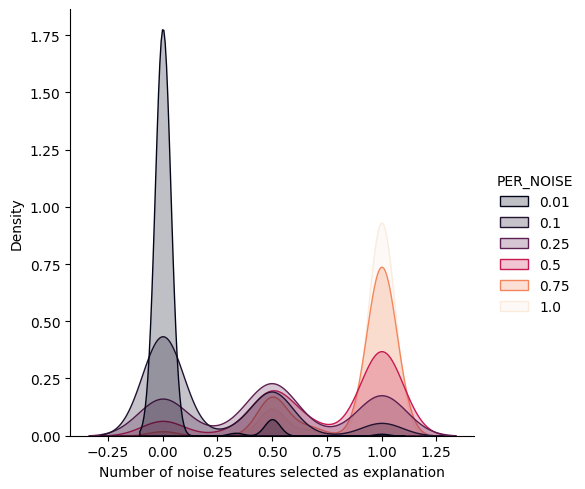

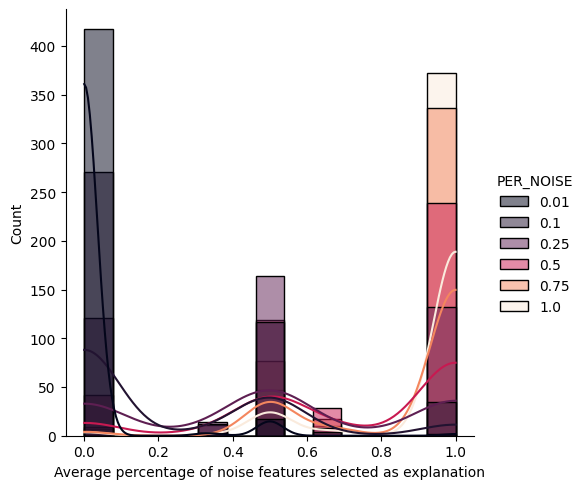

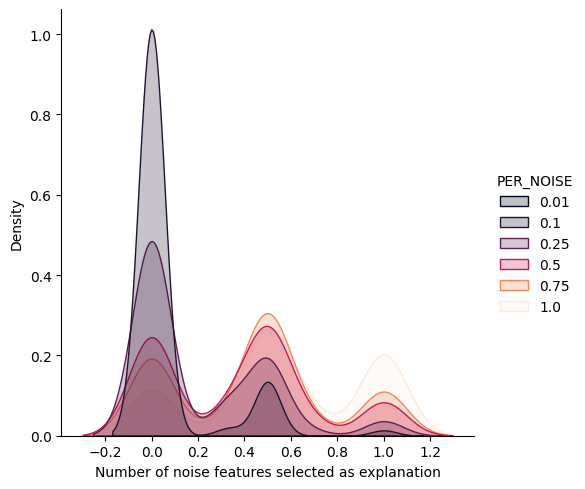

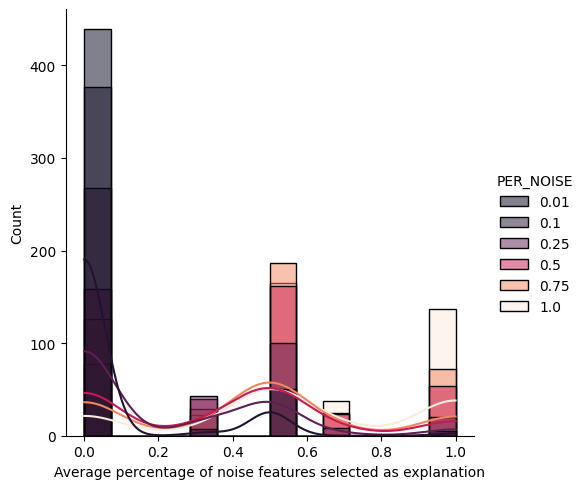

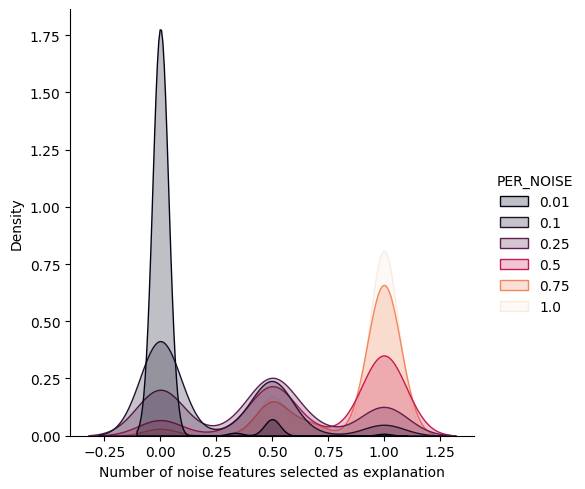

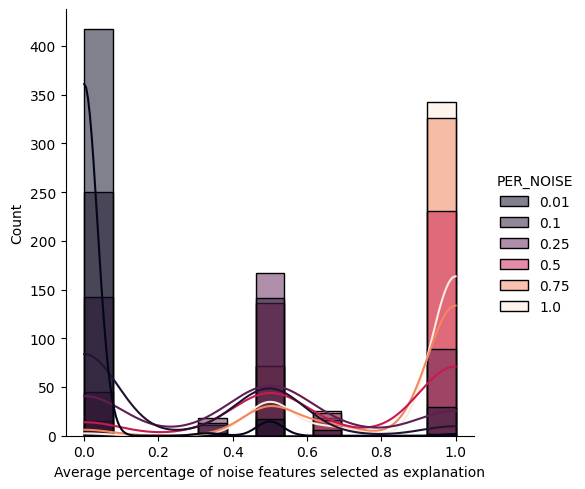

In [33]:
robustness_expand_df = robustness_df.drop(robustness_df[robustness_df['PER_NOISE'] == 0.0].index)

for feature_type in ['Graph-based', 'Text-based', 'Multimodal']:
    feature_type_robustness_expand_df = robustness_expand_df[robustness_expand_df['MODALITY'] == feature_type]
    feature_type_robustness_expand_df = feature_type_robustness_expand_df.explode(['NUM_NOISE_FEATS', 'PER_NOISE_FEATS'])
    feature_type = feature_type.split('-')[0].lower()

    sns.displot(data=feature_type_robustness_expand_df, x='PER_NOISE_FEATS', kind='kde', label='PER_NOISE', hue='PER_NOISE', fill=True, palette='rocket')
    plt.xlabel('Number of noise features selected as explanation')
    # plt.legend(title='Percentage of additional noise features in the input', loc='upper right')
    plt.savefig(f'./data/results/dist-v2-{feature_type}.pdf', dpi=300, bbox_inches='tight')

    sns.displot(data=feature_type_robustness_expand_df, x='PER_NOISE_FEATS', kde=True, label='PER_NOISE', hue='PER_NOISE', palette='rocket')
    plt.xlabel('Average percentage of noise features selected as explanation')
    # plt.legend(title='Percentage of additional noise features in the input', loc='upper right')
    plt.savefig(f'./data/results/hist-v2-{feature_type}.pdf', dpi=300, bbox_inches='tight')